# Program 3.04: Parameter sweep for `adh`using the constant friction model

## Preamble

In [ ]:
using NBInclude

In [ ]:
@nbinclude("preamble/packages.ipynb");

In [ ]:
@nbinclude("preamble/functions.ipynb");

In [ ]:
model = ABM(3,

	# Global parameters
	model = Dict(
		# Physical constants
		:range => Float64,
		:lambda => Float64,
		:mu => Float64,
		:adh => Array{Float64},
		# Division constants
		:tau_div => Float64,
		:sigma_div => Float64,
		:olap => Float64,
		:g_on => Bool,
		:d_on => Bool,
		:b => Float64,
		:p => Float64,
		:q => Float64,
		:k => Float64,
		# Noise parameters
		:fp => Float64,
		:kp_on => Float64,
		:kp_off => Float64,
		# Reference values
		:t0 => Float64,
		:r0 => Float64,
		:f0 => Float64,
		:rep => Float64,
	),


	# Local parameters
	agent = Dict(
		:t_div => Float64,
		:ni => Int64,
		:cell_state => Int64,
		# :m=>Float64,               
		:r => Float64,
		:vx => Float64,
		:vy => Float64,
		:vz => Float64,
		:fx => Float64,
		:fy => Float64,
		:fz => Float64,
		:ni_a => Float64,
		:r_ab => Float64,
		:r_bc => Float64,
		# Noise
		:fpx => Float64,
		:fpy => Float64,
		:fpz => Float64,
		:marked => Bool,
		:t_paired => Float64,
	), 
	
	
	agentODE = quote
		# Physical dynamics
		fx = 0
		fy = 0
		fz = 0
		ni = 0
		@loopOverNeighbors it2 begin
			dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
			if dij < mu * 2 * r && dij > 0
				if dij < 2 * r
					fx += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
					fy += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
					fz += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				else
					fx += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
					fy += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
					fz += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				end
			end
			if dij < range * 2 * r
				ni += 1
			end
		end
		if marked == true
			if t < t_paired
				fx += fpx
				fy += fpy
				fz += fpz
			else
				marked = false
			end
		end
		vx = fx / lambda
		vy = fy / lambda
		vz = fz / lambda
		dt(x) = vx
		dt(y) = vy
		dt(z) = vz
	end, 
	
	
	agentRule = quote
		# Growth
		if g_on
			if t > t_div
				x_div = CBMDistributions.normal(0, 1)
				y_div = CBMDistributions.normal(0, 1)
				z_div = CBMDistributions.normal(0, 1)
				norm_div = sqrt(x_div^2 + y_div^2 + z_div^2)
				x_div /= norm_div
				y_div /= norm_div
				z_div /= norm_div

				r_sep = r * olap
				@addAgent(
					x = x + r_sep * x_div,
					y = y + r_sep * y_div,
					z = z + r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@addAgent(
					x = x - r_sep * x_div,
					y = y - r_sep * y_div,
					z = z - r_sep * z_div,
					# vx = 0,
					# vy = 0,
					# vz = 0,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@removeAgent()
			end
		end

		# State evolution
		if d_on == true && cell_state != 3
			ni = 0
			ni_a = 0
			@loopOverNeighbors it2 begin
				dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
				if dij < range * 2 * r
					ni += 1
					if (cell_state[it2] == 1)
						ni_a += 1
					end
				end
			end

			if ni != 0
				ni_a /= ni
			end

			ran = CBMDistributions.uniform(0, 1)

			if cell_state == 1
				r_ab = p / (1 + k * ni_a)
				if ran < r_ab * dt
					cell_state = 2
				end

			elseif cell_state == 2
				r_bc = q / (1 + k * ni_a)
				if ran < r_bc * dt
					cell_state = 3
				end
			end
		end

	end, 
	
	
	agentAlg = CBMIntegrators.Heun(),
);


## Initialization

In [ ]:
# parameters = define_par(lambda=1);
parameters = define_par();

dt = 0.001;
save_each = round(Int64, 0.25 / dt);
n_cells = 900;


## Aggregate

In [ ]:
Random.seed!(2345)
reps = [1, 1.5, 2, 3]
ite = length(reps)
coms = Array{Community}(undef, ite);

for i in 1:ite
	com = initialize_growth(parameters; dt)
	com.rep = reps[i]
	grow_size!(com, save_each, n_cells)
	# grow_time!(com, save_each, 45)
	println("$(formed_correctly(com)), N=$(com.N)")
	plot_aggregate(com, color_map, 1, length(com), size = 7)
	coms[i] = com
end


In [ ]:
# for i in 1:ite
# 	com = coms[i]
# 	plot_aggregate(com, color_map, 1, length(com))
# end


## Why do neighbours increase?

In [ ]:
# println(mean_dist(com, 136))
# println(mean_dist(com, 181), "\n")
# println(mean_dist(com, 136)/ cm_dist(com, 136))
# println(mean_dist(com, 181)/ cm_dist(com, 181))

Least popular cell has 0 neighbours
Most popular cell has 103 neighbours, shown in the following plot.
Plot: timestamp 190


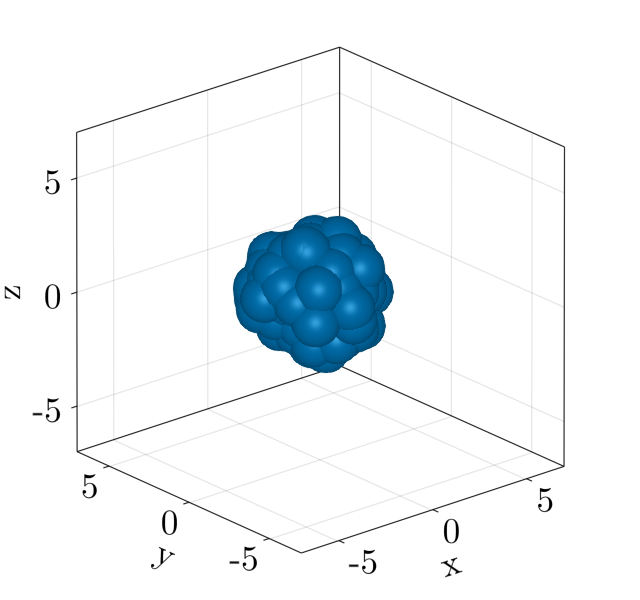

Least popular cell has 0 neighbours
Most popular cell has 57 neighbours, shown in the following plot.
Plot: timestamp 189


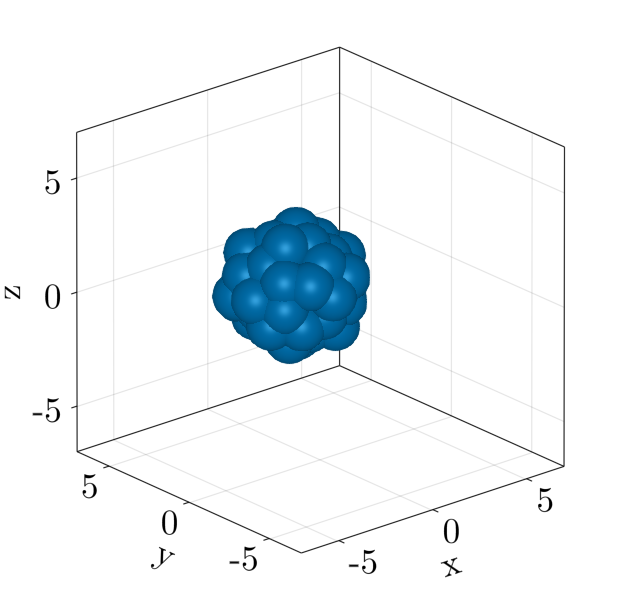

Least popular cell has 5 neighbours
Most popular cell has 30 neighbours, shown in the following plot.
Plot: timestamp 182


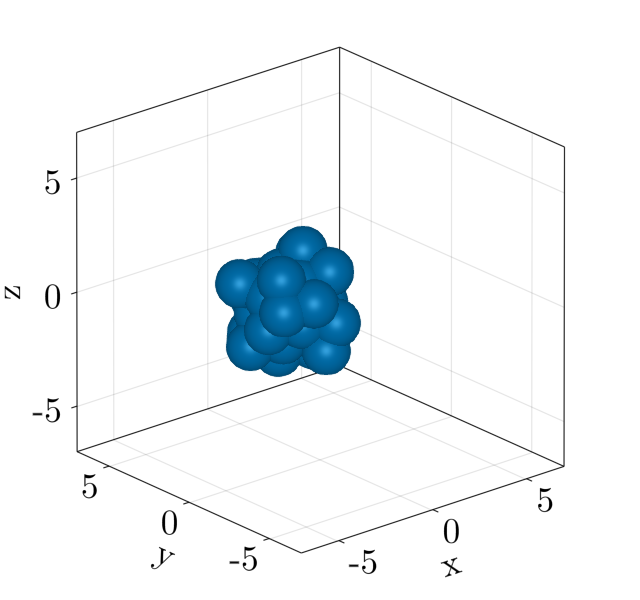

Least popular cell has 4 neighbours
Most popular cell has 18 neighbours, shown in the following plot.
Plot: timestamp 181


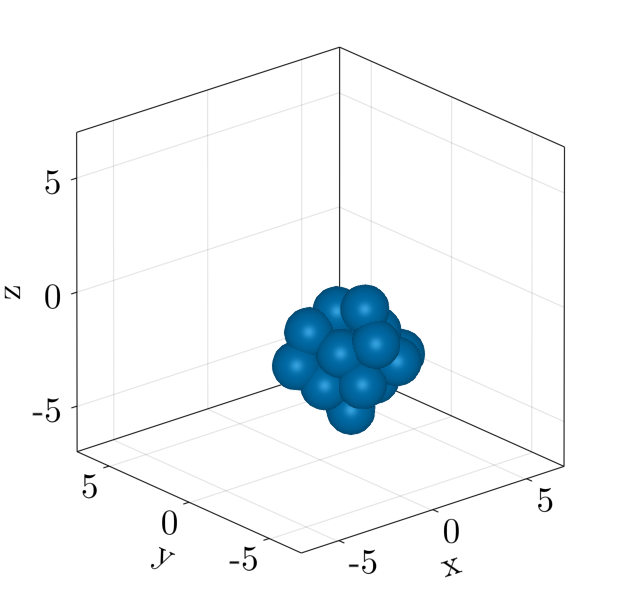

In [20]:
for i in 1:ite
	com = coms[i]
	ni = com.ni
	imax = argmax(ni)
	println("Least popular cell has $(ni[argmin(ni)]) neighbours")
	println("Most popular cell has $(ni[imax]) neighbours, shown in the following plot.")
	plot_aggregate_nbs(com, color_map, length(com), imax, size = 7)
end


## Number of neighbours

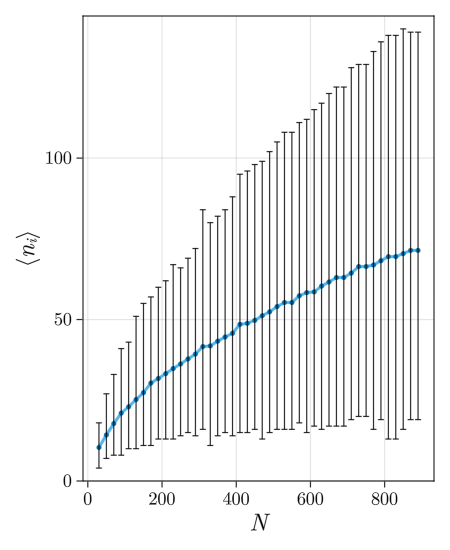

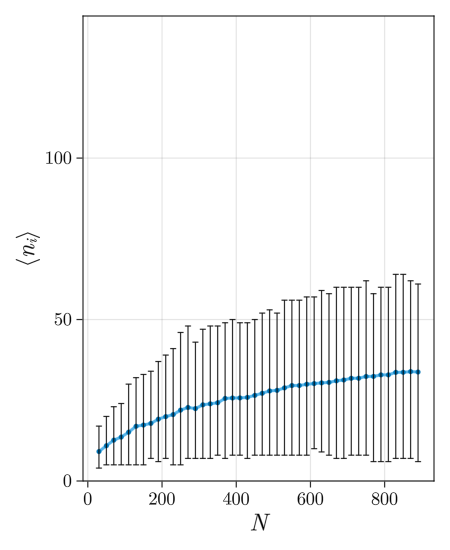

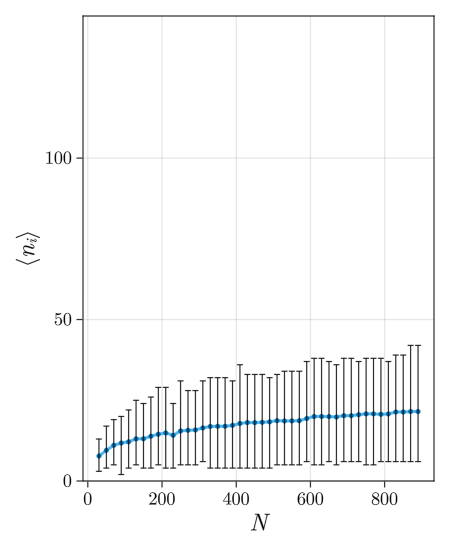

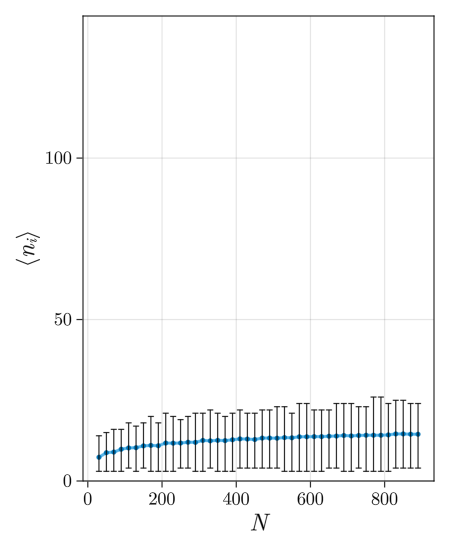

In [53]:
ylim = maximum(maximum(coms[i].ni) for i in 1:ite)

for i in 1:ite
	com = coms[i]

	x = (30:20:n_cells-1)
	avg_ni = [mean(com[find_instance(com, j)].ni) for j in x]
	# std_ni = [std(com[find_instance(com, j)].ni) for j in x];
	low_errors = avg_ni .- [minimum(com[find_instance(com, j)].ni) for j in x]
	high_errors = [maximum(com[find_instance(com, j)].ni) for j in x] .- avg_ni

	fig = Figure(resolution = (450, 550))
	ax = Axis(fig[1, 1], xlabel = L"N", ylabel = L"$\langle n_i \rangle$",
		xlabelsize = 24, ylabelsize = 24, xticklabelsize = 18, yticklabelsize = 18)
	ylims!(ax, 0, ylim + 5)

	lines!(ax, x, avg_ni, color = Makie.wong_colors()[5], linewidth = 3)
	scatter!(ax, x, avg_ni, color = Makie.wong_colors()[1], markersize = 7)
	errorbars!(ax, x, avg_ni, low_errors, high_errors,
		color = :black, whiskerwidth = 6, linewidth = 1)

	display(fig)
end
